# MANU 465 EEG Project
## Exploring Brainwaves vs Creative and Analytical Tasks
### By: Faith Tan, Emilie Ho, and Pan Tisapramotkul 

## Project Overview and Summary

### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

### Constants used

In [4]:
### CONSTANTS ###

SAMPLING_RATE = 256
CREATIVE_TRAIN_DIR = 'dataset/Drawing/Training'
CREATIVE_TEST_DIR = 'dataset/Drawing/Testing'
MATH_TEST_DIR = 'dataset/Mathematical/Testing'
MATH_TRAIN_DIR = 'dataset/Mathematical/Training'
RAW_CHANNEL = ['RAW_AF7', 'RAW_AF8', 'RAW_TP9', 'RAW_TP10']

## Importing Raw Data Collected

In [20]:
import os

# Get all the files path in the mathematical and creative directories appened in a list
math_test_files = [os.path.join(MATH_TEST_DIR, file) for file in os.listdir(MATH_TEST_DIR) if os.path.isfile(os.path.join(MATH_TEST_DIR, file))]
math_train_files = [os.path.join(MATH_TRAIN_DIR, file) for file in os.listdir(MATH_TRAIN_DIR) if os.path.isfile(os.path.join(MATH_TRAIN_DIR, file))]
creative_test_files = [os.path.join(CREATIVE_TEST_DIR, file) for file in os.listdir(CREATIVE_TEST_DIR) if os.path.isfile(os.path.join(CREATIVE_TEST_DIR, file))]
creative_train_files = [os.path.join(CREATIVE_TRAIN_DIR, file) for file in os.listdir(CREATIVE_TRAIN_DIR) if os.path.isfile(os.path.join(CREATIVE_TRAIN_DIR, file))]

print('Math test files:', len(math_test_files))
print('Math train files:', len(math_train_files))
print('Creative test files:', len(creative_test_files))
print('Creative train files:', len(creative_train_files))

Math test files: 2
Math train files: 11
Creative test files: 2
Creative train files: 9


## Data Preprocessing

### Divide Data into 15 seconds samples

In [21]:
from scipy.signal import hilbert
from math import floor, ceil


def divide_data(data, size):
    # Split the DataFrame into chunks
    num_chunks = floor(len(data) / size)
    data_list = []  # List to store chunks

    for i in range(num_chunks):
        start_idx = i * size
        end_idx = start_idx + size
        data_list.append(data.iloc[start_idx:end_idx])

    return data_list

### Clean up data (drop unncessary columns, calculate average, smooth out data, envolope brainwaves)

In [22]:
def cleaned_up_data(file : str):
    # get a dataframe
    dataset = pd.read_csv(file)
    
    # drop columns and NaN values
    dataset.drop(columns=['Battery','Elements'], inplace=True)
    dataset = dataset.dropna()

    brain_freq = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
    
    # envelope and smooth data
    for i in brain_freq:
        smooth_col_name = i + '_smooth_data'
        envelope_col_name = i + '_envelope'
        average_col_name = i + '_Average'

        dataset[average_col_name] = ((dataset[i + '_TP9'] + dataset[i + '_TP10'] + dataset[i + '_AF7'] + dataset[i + '_AF8']) / 4) * 100
        dataset[smooth_col_name] = moving_average(dataset[average_col_name].values, 1000)
        dataset[envelope_col_name] = np.abs(hilbert(dataset[smooth_col_name].values))

    return dataset

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

### Run code to get data

In [23]:

def get_all_data(file_list: list):
    """get data from all the files in the directory, 
    divide it into 20 seconds intervals and return the data"""

    all_data = []

    size = SAMPLING_RATE * 20

    # Transform each file in a list into a cleaned and processed dataframe
    for file in file_list:
        dataset = cleaned_up_data(file)
        data_list = divide_data(dataset, size=size)
        all_data.extend(data_list)
    
    return all_data

math_test_data : list[pd.DataFrame] = get_all_data(math_test_files)
math_train_data : list[pd.DataFrame] = get_all_data(math_train_files)
creative_test_data : list[pd.DataFrame] = get_all_data(creative_test_files)
creative_train_data : list[pd.DataFrame] = get_all_data(creative_train_files)


C:\Users\piram\AppData\Local\Temp\ipykernel_35076\3271502585.py:3: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(file)


## Feature Extraction

Get the peaks' amplitude, frequency, and area under the curve from the raw data collected by the four electrodes

### TODO: Make area under envelope brainwave curves features 

In [25]:
from scipy.signal import find_peaks
from numpy import trapezoid #type: ignore

def get_fft(dataset, channel : str):
    """Perform FFT on the data of the channel specfied from the range of 0.5 to 50 Hz

    Args:
        dataset (pd.DataFrame): _description_
        channel (str): _description_

    Returns:
        _type_: _description_
    """
    dataset = dataset[channel]

    # Perform FFT 
    n = len(dataset)                 # length of the signal
    k = np.arange(n)
    T = n/SAMPLING_RATE
    frq = k/T                 # two sides frequency range
    zz=int(n/2)

    freq = frq[range(zz)]           # one side frequency range
    Y = np.fft.fft(dataset)/n              # fft computing and normalization
    Y = abs(Y[range(zz)])

    # get only frequency from 0.5 to 50 Hz
    freq_mask = (freq>0.5) & (freq<55)
    filtered_freq = freq[freq_mask]
    filtered_Y = Y[freq_mask]
    
    return filtered_freq, filtered_Y
    
def get_peaks(filtered_freq, filtered_Y):
    # if max(filtered_freq) > 60:
    #     print("Warning: Detected frequency Higher than 60 Hz. Please remove it before continuing")
    #     return 
    
    # Get the peaks
    peaks, properties = find_peaks(filtered_Y, height=10)
    peak_heights = properties['peak_heights']

    # Get top 5 peaks
    if len(peaks) > 5:
        top_5_indices = np.argsort(peak_heights)[-5:][::-1]  # Indices of top 5 peaks
        peaks = peaks[top_5_indices]
        peak_heights = peak_heights[top_5_indices]
    
    # Sort the top 5 peaks in chronological order (by their indices)
    sorted_indices = np.argsort(peaks)
    peaks = peaks[sorted_indices]
    peak_heights = peak_heights[sorted_indices]

    return [filtered_freq[i] for i in peaks], peak_heights

def get_fft_area(freq, filtered_Y):
    gamma_mask = (freq>30) & (freq<55)
    beta_mask = (freq>13) & (freq<30)
    alpha_mask = (freq>8) & (freq<13)
    theta_mask = (freq>4) & (freq<8)
    delta_mask = (freq>1) & (freq<4)

    frequency_masks = [gamma_mask, beta_mask, alpha_mask, theta_mask, delta_mask]

    return [trapezoid(filtered_Y[mask], dx=1) for mask in frequency_masks]

def get_area_under_db_curve(data, dx=1):
    brain_freq = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

    return [trapezoid(data[y + '_envelope'], dx=1) for y in brain_freq] 

def find_max_electrode(data: pd.DataFrame):
    mean_dict = {
        'RAW_AF7': float(data['RAW_AF7'].abs().max() - data['RAW_AF7'].abs().min()), 
        'RAW_AF8': float(data['RAW_AF8'].abs().max() - data['RAW_AF8'].abs().min()), 
        'RAW_TP9': float(data['RAW_TP9'].abs().max() - data['RAW_TP9'].abs().min()), 
        'RAW_TP10': float(data['RAW_TP10'].abs().max() - data['RAW_TP10'].abs().min())
        }

    return max(mean_dict, key=mean_dict.get) 

def feature_extraction(all_data : list[pd.DataFrame]):
    feature_data = []

    # for each file 
    for i, data in enumerate(all_data):
        # initialize lists
        peaks_list = []
        amplitude_list = []
        area_list = []
        db_area_list = []

        # extract data from electrodes USING MAX ELECTRODE RAW DATA
        channel = find_max_electrode(data)
        freq, y = get_fft(data, channel)
        peaks, peak_heights = get_peaks(freq, y) # type: ignore
        area = get_fft_area(freq, y)
        db_area = get_area_under_db_curve(data)

        peaks_list.extend(peaks)
        amplitude_list.extend(peak_heights)
        area_list.extend(area)
        db_area_list.extend(db_area)

        data_info = peaks_list + amplitude_list + area_list + db_area_list
        feature_data.append(data_info)

    # Convert to DataFrame
    feature_data = pd.DataFrame(feature_data)

    return feature_data

def plot_samples(files: list[str], channel=None):
    """Plot the FFT of the data from the files list given

    Args:
        files (list[str]): _description_
        channel (_type_, optional): _description_. Defaults to None.
    """
    plt.figure(figsize=(20, 20)) 
    ax = plt.axes()

    for i, file in enumerate(files):
        data = cleaned_up_data(file)

        if channel is None:
            max_channel = find_max_electrode(data)
        else:
            max_channel = channel

        freq, y = get_fft(data, max_channel)
        ax = plt.subplot(ceil(len(files) / 2), 2, i+1)
        plt.plot(freq, y)
        plt.title(file + " " + max_channel)

        plt.xlim(0.5, 100)
        ax.set_ylim(0, 100)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()

all_features_math_test = feature_extraction(math_test_data)
all_features_math_train = feature_extraction(math_train_data)
all_features_creative_test = feature_extraction(creative_test_data)
all_features_creative_train = feature_extraction(creative_train_data)

# print lengths to confirm 
print(len(all_features_math_test))
print(len(all_features_math_train))
print(len(all_features_creative_test))
print(len(all_features_creative_train))

# Add labels to the data
all_features_math_test['label'] = 0
all_features_math_train['label'] = 0
all_features_creative_test['label'] = 1
all_features_creative_train['label'] = 1

35
140
26
111


## Exploratory Data Analysis

### Splitting Dateset into the Training and Test Sets

In [29]:
from sklearn.model_selection import train_test_split

# Combine the two DataFrames
train_combined_df = pd.concat([all_features_math_train, all_features_creative_train], ignore_index=True)
test_combined_df = pd.concat([all_features_math_test, all_features_creative_test], ignore_index=True)

# Shuffle the combined DataFrame
all_train_df = train_combined_df.sample(frac=1).reset_index(drop=True)
all_train_df.columns = ['Peak1', 'Peak2', 'Peak3', 'Peak4', 'Peak5', 'Amplitude1', 'Amplitude2', 'Amplitude3', 'Amplitude4', 'Amplitude5', 'Area1', 'Area2', 'Area3', 'Area4', 'Area5', 'DeltaArea', 'ThetaArea', 'AlphaArea', 'BetaArea', 'GammaArea', 'Label']
all_train_df.dropna(inplace=True)

all_test_df = test_combined_df.sample(frac=1).reset_index(drop=True)
all_test_df.columns = ['Peak1', 'Peak2', 'Peak3', 'Peak4', 'Peak5', 'Amplitude1', 'Amplitude2', 'Amplitude3', 'Amplitude4', 'Amplitude5', 'Area1', 'Area2', 'Area3', 'Area4', 'Area5', 'DeltaArea', 'ThetaArea', 'AlphaArea', 'BetaArea', 'GammaArea', 'Label']
all_test_df.dropna(inplace=True)

all_df = pd.concat([all_train_df, all_test_df], ignore_index=True)

### Plotting Histograms

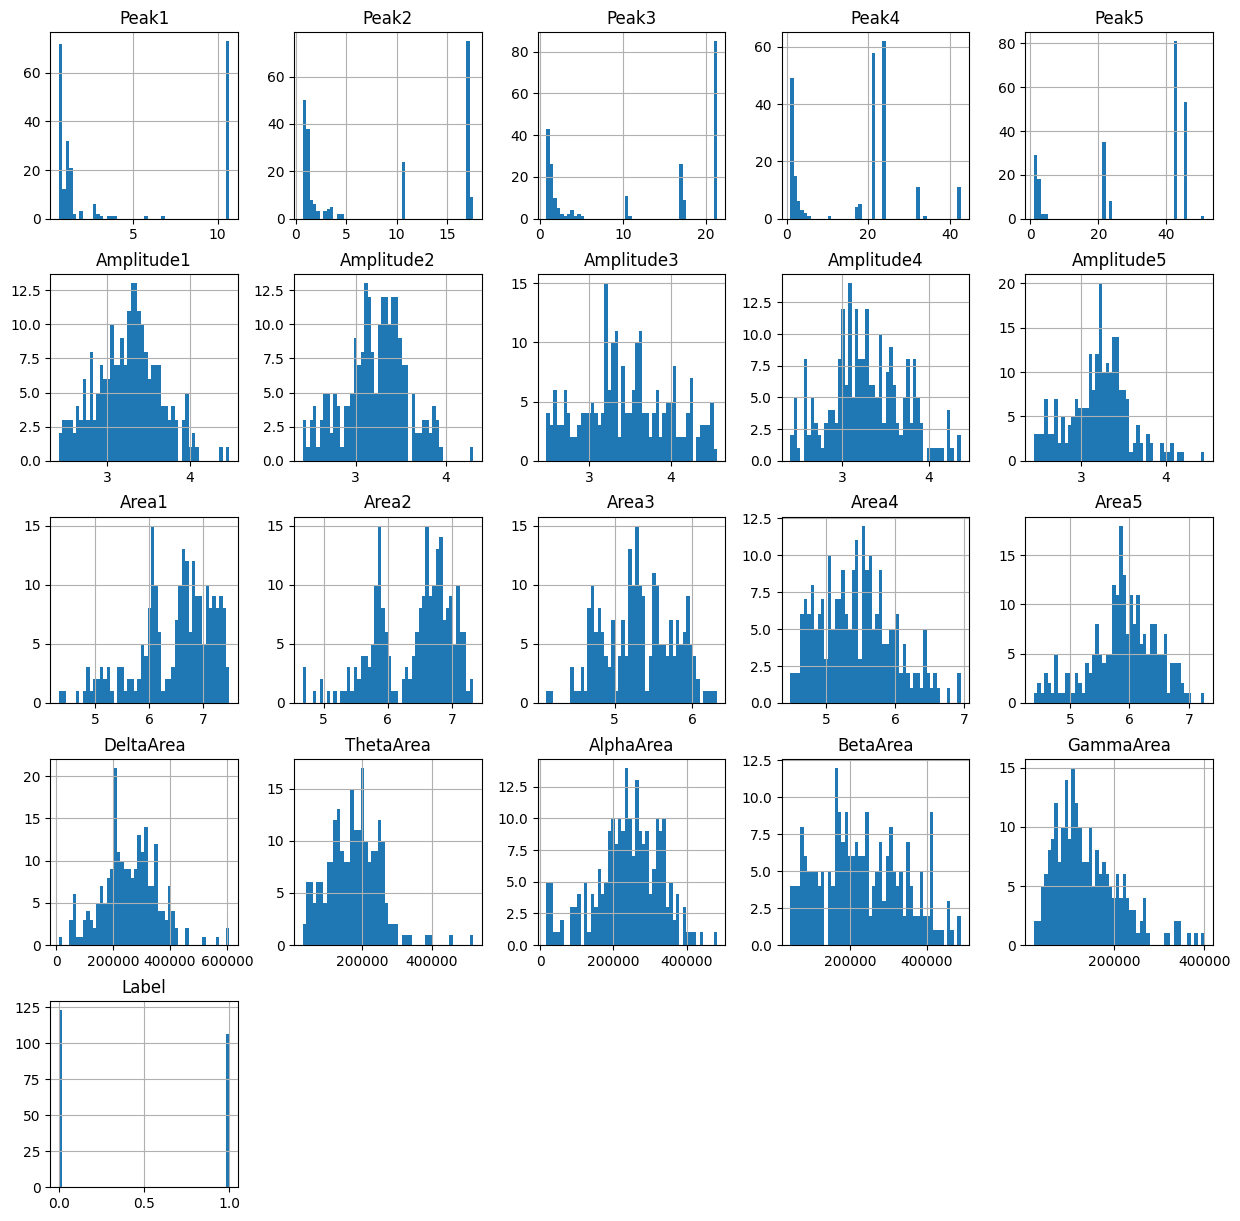

In [30]:
# Applying log transform to a column
for col in ['Amplitude1', 'Amplitude2', 'Amplitude3', 'Amplitude4', 'Amplitude5', 'Area1', 'Area2', 'Area3', 'Area4', 'Area5']:
    all_df[col] = np.log(all_df[col] + 1)  # Add 1 to avoid log(0)

all_df[:-1].hist(bins=50, figsize=(15,15))
plt.show()


### Manual Test and Train Splitting (To prevent data leakage)

In [32]:
# X = all_df.iloc[:, :-1]
# y = all_df.iloc[:, -1]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

X_train = all_train_df.iloc[:, :-1]
X_test = all_test_df.iloc[:, :-1]
y_train = all_train_df.iloc[:, -1]
y_test = all_test_df.iloc[:, -1]

### Removing Outliers using IQW Method

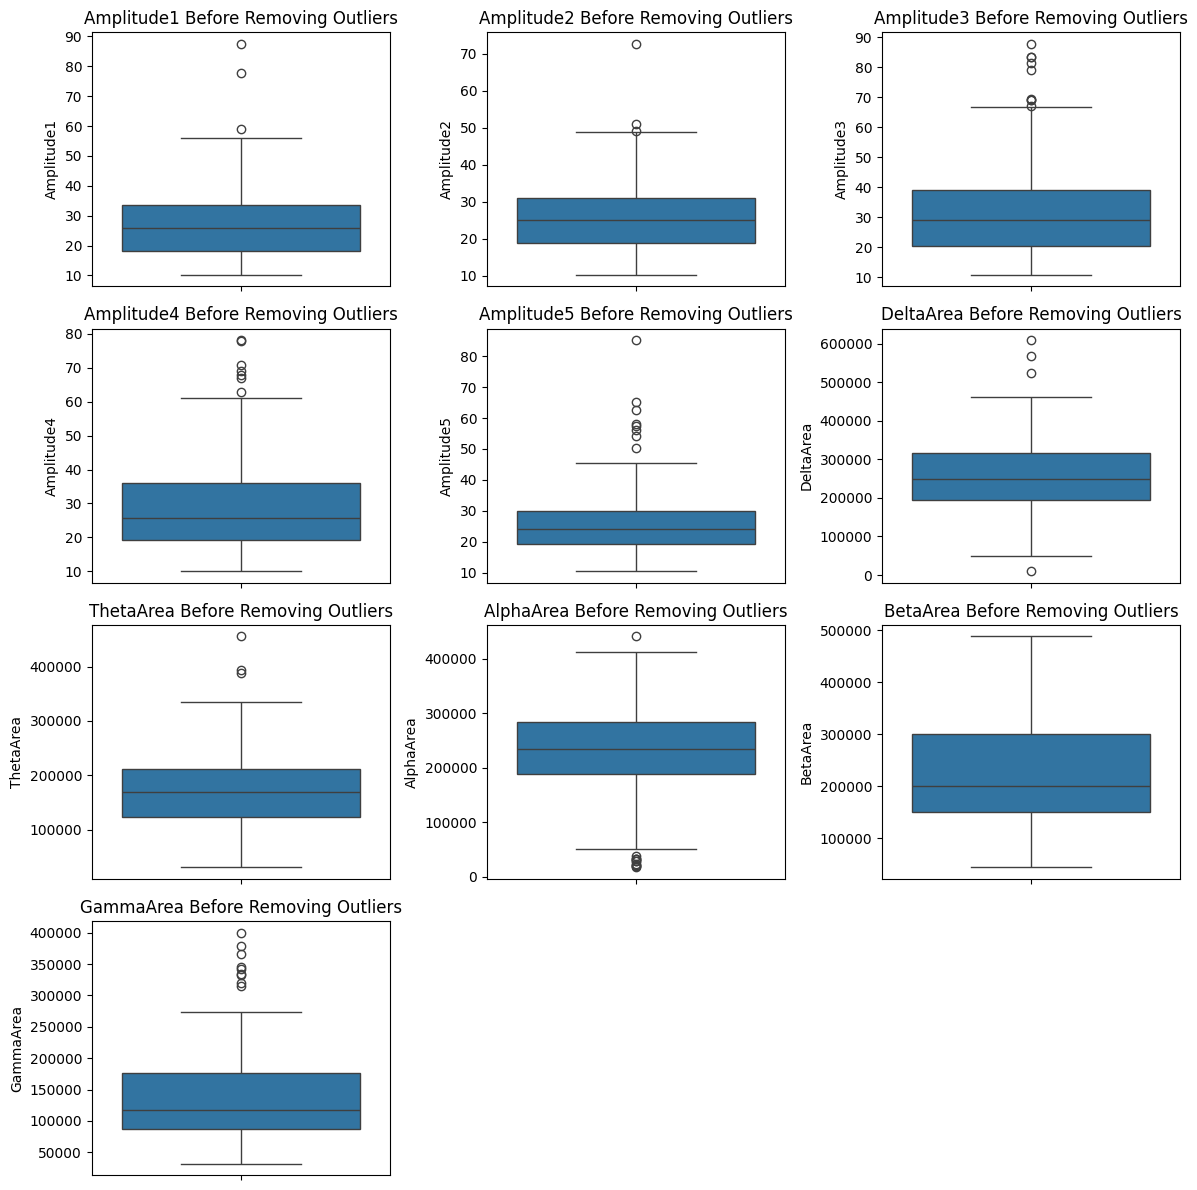

In [33]:
# Plot data before remoivng outliers
plt.figure(figsize=(12, 12))

outlier_list = ['Amplitude1', 'Amplitude2', 'Amplitude3', 'Amplitude4', 'Amplitude5', 'DeltaArea', 'ThetaArea', 'AlphaArea', 'BetaArea', 'GammaArea']
for index, col in enumerate(outlier_list):
    plt.subplot(4, 3, index+1)
    sns.boxplot(y=X_train[col])
    plt.title(col + ' Before Removing Outliers')

plt.tight_layout()
plt.show()

In [35]:
# Function to remove outliers and corresponding rows from X and y
def remove_outliers_from_both(X, y, column):
    Q1 = X[column].quantile(0.25)
    Q3 = X[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.2 * IQR
    upper_bound = Q3 + 1.2 * IQR

    # Keep only the rows where the values are within the bounds
    mask = (X[column] >= lower_bound) & (X[column] <= upper_bound)
    
    # Return the filtered X and y (rows without outliers)
    return X[mask], y[mask]

# Remove outliers from Amplitudes
for col in ['Amplitude1', 'Amplitude2', 'Amplitude3', 'Amplitude4', 'Amplitude5']:
    X_train, y_train = remove_outliers_from_both(X_train, y_train, col)

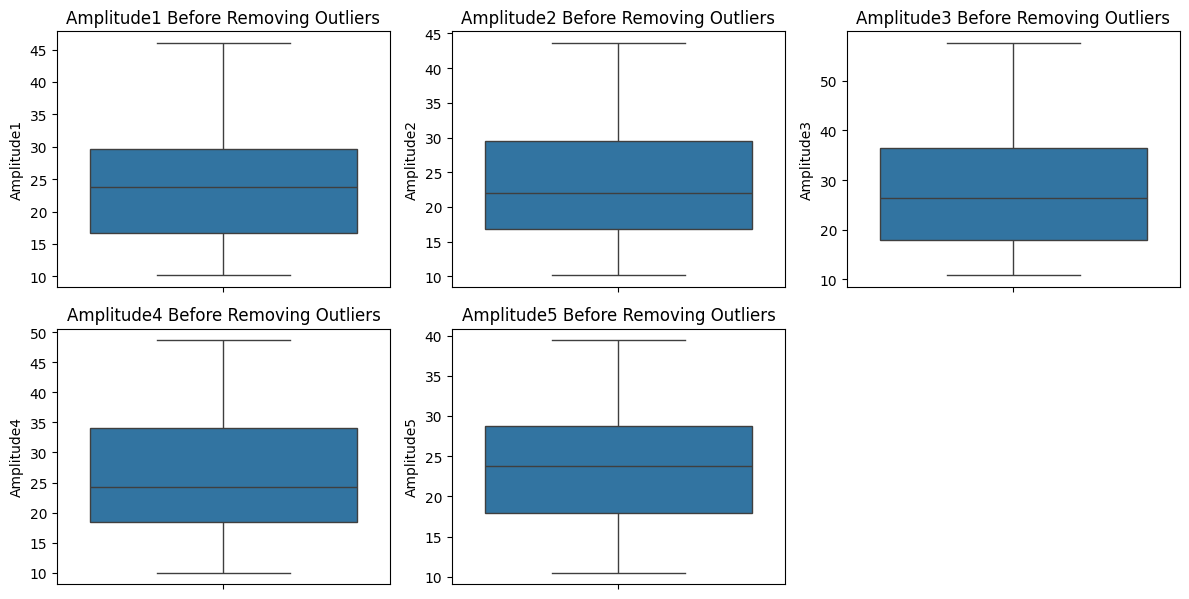

In [36]:
# Plot data after removing outliers
plt.figure(figsize=(12, 12))

outlier_list = ['Amplitude1', 'Amplitude2', 'Amplitude3', 'Amplitude4', 'Amplitude5']
for index, col in enumerate(outlier_list):
    plt.subplot(4, 3, index+1)
    sns.boxplot(y=X_train[col])
    plt.title(col + ' Before Removing Outliers')

plt.tight_layout()
plt.show()

### Feature Scaling

In [37]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


### Correlation Matrix

Label         1.000000
Peak1         0.253476
Amplitude3    0.194457
Peak2         0.164194
Peak4         0.152783
Peak3         0.143533
Peak5         0.019253
GammaArea    -0.004586
DeltaArea    -0.019890
Amplitude2   -0.046276
AlphaArea    -0.092053
Amplitude1   -0.112164
BetaArea     -0.122064
Area2        -0.198756
Amplitude5   -0.221629
Area1        -0.228349
ThetaArea    -0.268588
Amplitude4   -0.285618
Area3        -0.323621
Area5        -0.397979
Area4        -0.470133
Name: Label, dtype: float64

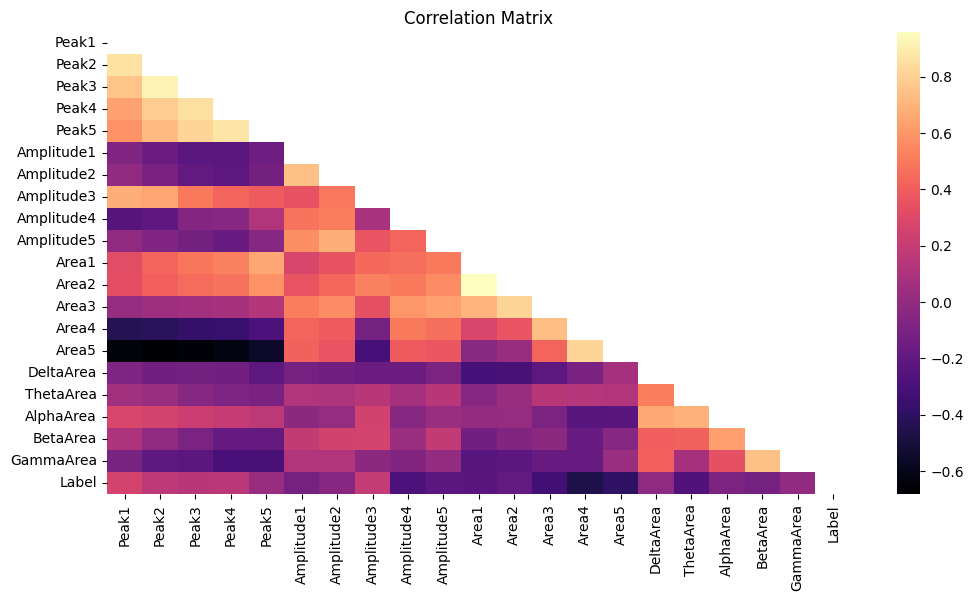

In [38]:
from seaborn import heatmap

# creating the correlation matrix
corr_matrix = all_df.corr()

# visualizing the correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  
plt.figure(figsize=(12, 6))  # to set the figure size
heatmap(corr_matrix, mask=mask, annot=False, lw=0, linecolor='white', cmap='magma', fmt='0.2f')
plt.title("Correlation Matrix")  # to add title 
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# getting the correlation values with the purchased column
corr_matrix['Label'].sort_values(ascending=False)  

### Graph 1: Showing Correlationship between area under each frequency range (Brain activity) and the type of task (Drawing vs Math)

[Text(0, 0, 'Gamma'),
 Text(1, 0, 'Beta'),
 Text(2, 0, 'Alpha'),
 Text(3, 0, 'Theta'),
 Text(4, 0, 'Delta')]

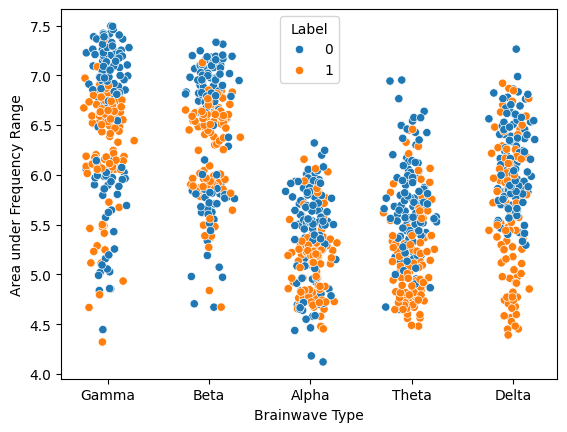

In [69]:
for i in range(5):
    if i == 0:
        d = sns.scatterplot(data=all_df, x=[0.1 * np.random.randn() + i for j in range(len(all_df))], y='Area'+str(i+1), hue='Label', legend=True)
    else:
        d = sns.scatterplot(data=all_df, x=[0.1 * np.random.randn() + i for j in range(len(all_df))], y='Area'+str(i+1), hue='Label', legend=False)

d.set_ylabel('Area under Frequency Range')
d.set_xlabel('Brainwave Type')
d.set_xticks([0,1,2,3,4])
d.set_xticklabels(['Gamma', 'Beta', 'Alpha', 'Theta', 'Delta'])

### Principal Component Analysis (PCA)

In [40]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
pca.fit(X_train)
Z=pca.transform(X_train)

loadings = pd.DataFrame(
    pca.components_,
    columns=all_df.columns[:-1],
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)
print(loadings)

        Peak1     Peak2    Peak3     Peak4     Peak5  Amplitude1  Amplitude2  \
PC1  0.217376  0.258104  0.25058  0.253643  0.274955    0.165886    0.161478   
PC2 -0.254923 -0.291052 -0.30845 -0.290971 -0.245324    0.269827    0.299463   

     Amplitude3  Amplitude4  Amplitude5     Area1     Area2     Area3  \
PC1    0.281226    0.190277    0.242745  0.366306  0.377153  0.311145   
PC2   -0.040491    0.212317    0.230287  0.026522  0.056660  0.223411   

        Area4     Area5  DeltaArea  ThetaArea  AlphaArea  BetaArea  GammaArea  
PC1  0.177063  0.024008  -0.091819   0.102302   0.089158 -0.018844  -0.152410  
PC2  0.327657  0.400425  -0.028963   0.108887  -0.069806  0.092717   0.019696  


## Building Machine Learning Models

### Classification: Support Vector Machine (SVM)

In [41]:
from sklearn.svm import SVC

classifier = SVC(kernel = 'rbf', random_state = 0) ## try differernals and remove the random_state maybe
classifier.fit(X_train, y_train)

SVC(random_state=0)

### SVM: Confusion Matrix

In [42]:
from sklearn.metrics import confusion_matrix, accuracy_score
print(len(X_train))
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Your Model Accuracy is=", accuracy_score(y_test, y_pred)*100, "%")

139
[[19  2]
 [ 4 20]]
Your Model Accuracy is= 86.66666666666667 %


In [43]:
# KNN Classifier
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Your Model Accuracy is=", accuracy_score(y_test, y_pred)*100, "%")

[[17  4]
 [ 5 19]]
Your Model Accuracy is= 80.0 %


### SVM: Prediction a new Result

### Neural Network (ANN) Model

Epoch 1/35
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5798 - loss: 0.6865
Epoch 2/35
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5728 - loss: 0.6811
Epoch 3/35
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6458 - loss: 0.6539
Epoch 4/35
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6223 - loss: 0.6349
Epoch 5/35
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6919 - loss: 0.6066 
Epoch 6/35
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7379 - loss: 0.5697
Epoch 7/35
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8025 - loss: 0.5335
Epoch 8/35
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8041 - loss: 0.5197 
Epoch 9/35
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8069 - loss: 0.4764
Epoch 10/35
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8667 - loss: 0.4488
Epoch 11/35
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8814 - loss: 0.4107
Epoch 12/35
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9032 - 

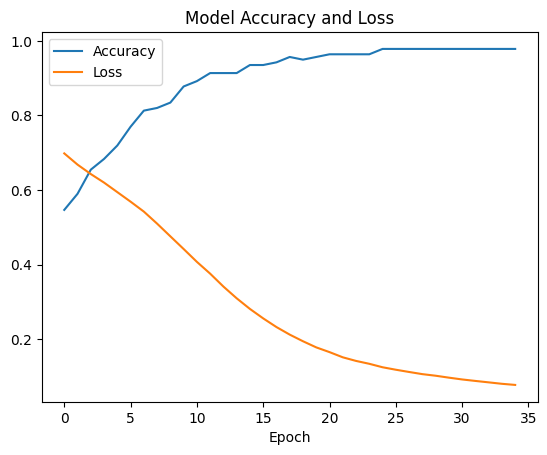

In [44]:
eegModel = tf.keras.models.Sequential()
eegModel.add(tf.keras.layers.Dense(15,activation='relu'))
eegModel.add(tf.keras.layers.Dense(units=8, activation='relu'))
eegModel.add(tf.keras.layers.Dense(1,activation='sigmoid'))

eegModel.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history = eegModel.fit(X_train, y_train, batch_size = 8, epochs = 35)

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model Accuracy and Loss')
plt.legend(['Accuracy', 'Loss'])
plt.xlabel('Epoch')
plt.show()  

In [45]:
y_pred = eegModel.predict(X_test)
eegModel.evaluate(X_test,y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7937 - loss: 0.6017


[0.592778205871582, 0.800000011920929]

## Feature Extraction for Short Term Fourier Transform

In [ ]:
OVERLAP = 20
WINDOWSIZE = 32
STFT_DIR_MATH = 'STFT_Images/Mathematical'
STFT_DIR_DRAWING = 'STFT_Images/Drawing'

def get_stft(all_data : list[pd.DataFrame], dir_path : str):
    for i, data in enumerate(all_data):
        channel = find_max_electrode(data)
        Pxx, freqs, bins, im = plt.specgram(data[channel], NFFT=WINDOWSIZE, Fs=SAMPLING_RATE, noverlap=OVERLAP)
        plt.tick_params(         # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            bottom=False,         # ticks along the top edge are off
            labelbottom=False,
            labelleft=False) # labels along the bottom edge are off
        plt.savefig(os.path.join(dir_path, f'{i}.png'))
        return

## DO NOT UNDER COMMENT THIS ## 
# Code use to generate spectrograms which has been done already - takes a long time to run lol
# get_stft(all_math_data[0:2], STFT_DIR_MATH)
# get_stft(all_drawing_data, STFT_DIR_DRAWING)

### Put spectrogram images in test and train folders

In [47]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
input_dir = "STFT_Images"  # Directory containing class1, class2, etc.
output_dir = "STFT_Split_Images"  # Destination for train/test splits
train_ratio = 0.8  # Proportion of data to use for training

# Create output directories
for split in ['train', 'test']:
    split_path = os.path.join(output_dir, split)
    for class_name in os.listdir(input_dir):
        os.makedirs(os.path.join(split_path, class_name), exist_ok=True)

# Split the data
for class_name in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_name)
    images = os.listdir(class_path)
    
    # Train-test split
    train_files, test_files = train_test_split(images, train_size=train_ratio, random_state=42)
    
    # Move files to respective directories
    for file_name in train_files:
        shutil.copy(os.path.join(class_path, file_name), os.path.join(output_dir, 'train', class_name))
    for file_name in test_files:
        shutil.copy(os.path.join(class_path, file_name), os.path.join(output_dir, 'test', class_name))

print(f"Data has been split and saved to '{output_dir}'")


Data has been split and saved to 'STFT_Split_Images'


## Import in generated spectrograms

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,  # Center pixel values
    featurewise_std_normalization=True,  # Normalize pixel values
)

training_set = train_datagen.flow_from_directory(
    directory=r"STFT_Split_Images\train",
    target_size=(64, 64),  # Adjust to your image size
    batch_size=16,  # Batch size
    class_mode='binary',  # Set the appropriate class mode
)

# Preprocssing the Test Set
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(r"STFT_Split_Images\test",
                                            target_size = (64, 64),
                                            batch_size = 16,
                                            class_mode ='binary')
print(len(test_set))

training_set.class_indices

Found 249 images belonging to 2 classes.
Found 63 images belonging to 2 classes.
4


{'Drawing': 0, 'Mathematical': 1}

## Building a 2D Convolutional Neural Network 

In [61]:
Model = tf.keras.models.Sequential() # Initialize the Model 
Model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3])) # Adding First Convolution Layer
Model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2)) # Pooling the first layer
Model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')) # Adding a second convolutional layer
Model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2)) # Pooling the Second Layer
Model.add(tf.keras.layers.Flatten()) # Flattening
Model.add(tf.keras.layers.Dense(units=128, activation='relu')) # Full Connection
Model.add(tf.keras.layers.Dense(units=1, activation='sigmoid')) # Output Layer

print("Successfully Build a CNN Model!")

Successfully Build a CNN Model!


## Compile the Model

In [62]:
# Compiling the CNN Model
Model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

## Training the CNN and Evaluation 

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - accuracy: 0.4673 - loss: 0.8513 - val_accuracy: 0.5556 - val_loss: 0.6874
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - accuracy: 0.5692 - loss: 0.6858 - val_accuracy: 0.5556 - val_loss: 0.6867
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.5448 - loss: 0.6863 - val_accuracy: 0.5556 - val_loss: 0.6941
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.5735 - loss: 0.6767 - val_accuracy: 0.5556 - val_loss: 0.6863
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.5956 - loss: 0.6717 - val_accuracy: 0.5556 - val_loss: 0.6869
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 0.5886 - loss: 0.6750 - val_accuracy: 0.5238 - val_loss: 0.6875
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - accuracy: 0.5690 - loss: 0.6801 - val_accuracy: 0.5556 - val_loss: 0.7164
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.5706 - loss: 0.6801 - val_accuracy: 0.

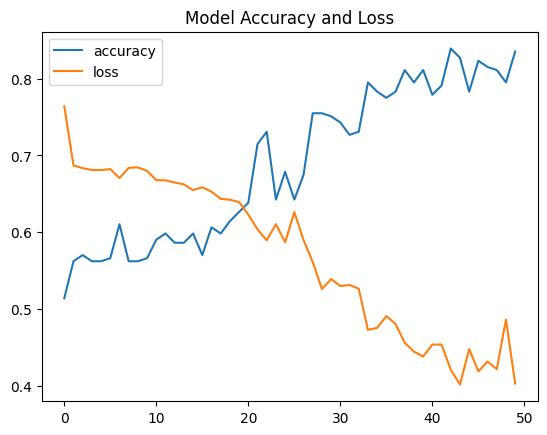

In [63]:
# Training the CNN Model
history = Model.fit(x = training_set, validation_data = test_set, epochs = 50, batch_size=8)

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model Accuracy and Loss')
plt.legend(['accuracy', 'loss'])
plt.show()

In [70]:
accuracy = Model.evaluate(test_set)
print(f"Accuracy: {accuracy[1]*100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.7505 - loss: 0.6756
Accuracy: 74.60%
